# Plot boxplots

In [1]:
library(repr)
library(ggpubr)
library(tidyverse)

Loading required package: ggplot2

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Functions

In [2]:
save_ggplots <- function(fn, p, w, h){
    for(ext in c('.pdf', '.png', '.svg')){
        ggsave(paste0(fn, ext), plot=p, width=w, height=h)
    }
}

## Disconcordant expression

### Load phenotype data

In [3]:
pheno_file = '../../../../../../../input/phenotypes/merged/_m/merged_phenotypes.csv'
pheno = read.csv(pheno_file, row.names=1) %>% 
    select("RNum", "Region", "Sex", "Race", "Dx")
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Race) <- c("AA", "AS", "EA", "HISP")
head(pheno, 2)

,RNum,Region,Sex,Race,Dx
,<chr>,<chr>,<chr>,<chr>,<chr>
R12864,R12864,Caudate,F,AA,Schizo
R12865,R12865,Caudate,M,AA,Schizo


### Caudate vs DLPFC

In [4]:
fn = '../../_m/disconcordant_genes_caudate_dlpfc.csv'
topCD = data.table::fread(fn) %>% head(5) %>% 
    select(Feature, Symbol, Dir_caudate, Dir_dlpfc, adj.P.Val)
topCD

Feature,Symbol,Dir_caudate,Dir_dlpfc,adj.P.Val
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ENSG00000277883.1,NLRP3P1,1,-1,6.562210e-07
ENSG00000070601.9,FRMPD1,1,-1,1.220536e-02
ENSG00000006625.17,GGCT,-1,1,1.784174e-02
ENSG00000100302.6,RASD2,1,-1,2.019820e-02
ENSG00000198034.10,RPS4X,-1,1,2.940114e-02


### Load residualized data and merge with phenotypes

In [6]:
res_file = '../../../../../../region_race_interaction/_m/genes/residualized_expression.tsv'
cvd_df = data.table::fread(res_file) %>% 
    filter(Geneid %in% topCD$Feature) %>% 
    column_to_rownames(var="Geneid") %>% 
    t %>% as.data.frame %>% 
    rownames_to_column %>% 
    inner_join(pheno, by=c("rowname" = "RNum")) %>% 
    pivot_longer(-c("rowname", "Region", "Sex", "Race", "Dx"), 
                 names_to="GencodeID", values_to="Res") %>% 
    rename(RNum=rowname) %>% 
    inner_join(topCD, by=c("GencodeID"="Feature")) %>% 
    mutate_if(is.character, as.factor) 
cvd_df$Race <- factor(droplevels(cvd_df$Race))
cvd_df$Region <- factor(droplevels(cvd_df$Region))
cvd_df$Symbol <- factor(droplevels(cvd_df$Symbol))
cvd_df$Symbol = with(cvd_df, reorder(Symbol, adj.P.Val, median))
cvd_df %>% head(2)

RNum,Region,Sex,Race,Dx,GencodeID,Res,Symbol,Dir_caudate,Dir_dlpfc,adj.P.Val
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
R10424,DLPFC,M,CAUC,Control,ENSG00000006625.17,0.1452778,GGCT,-1,1,0.01784174
R10424,DLPFC,M,CAUC,Control,ENSG00000070601.9,0.3848671,FRMPD1,1,-1,0.01220536


### Initial ggplot with ggpubr

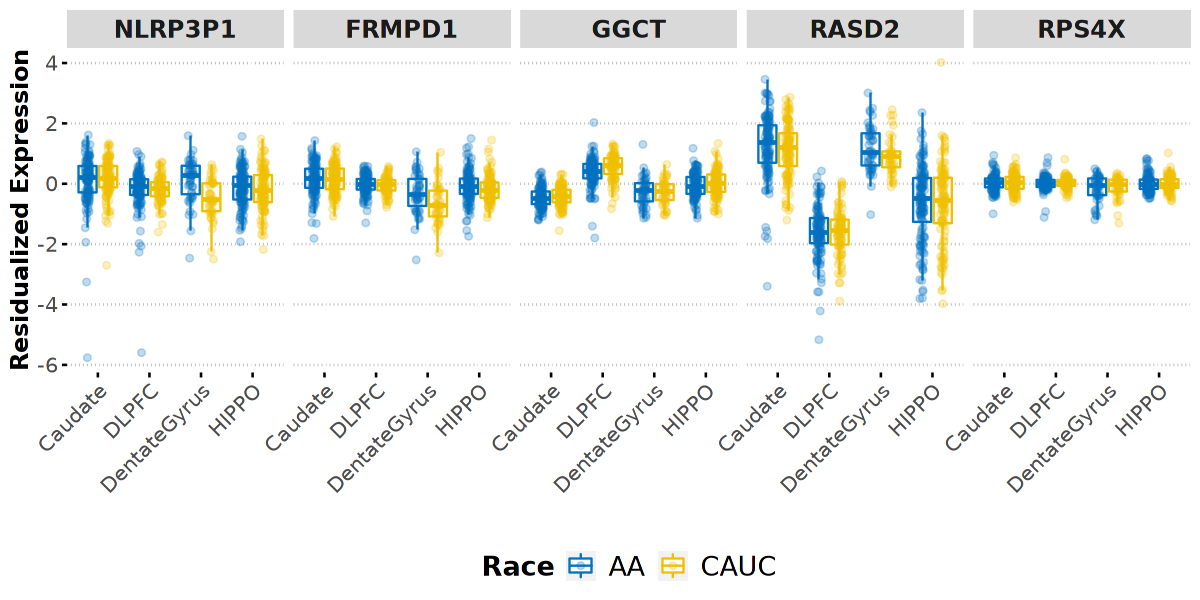

In [7]:
options(repr.plot.width=10, repr.plot.height=5)
bxp_cvd <- ggboxplot(cvd_df, x="Region", y="Res", color="Race", palette="jco",
                     facet.by=c("Symbol"), add='jitter', ncol=5, #ylim=c(-6, 3), 
                     add.params=list(alpha=0.25), xlab='', outlier.shape=NA,
                     panel.labs.font=list(face='bold', size = 14), legend='bottom',
                     ylab='Residualized Expression', ggtheme=theme_pubclean()) +
        font("xy.text", size=12) + font("xy.title", size=14, face="bold") + 
        font("legend.title", size=16, face="bold") + 
        font("legend.text", size=16) + rotate_x_text(45)  
bxp_cvd

### Caudate vs Hippocampus

In [8]:
fn = '../../_m/disconcordant_genes_caudate_hippo.csv'
topCH = data.table::fread(fn) %>% head(5) %>% 
    select(Feature, ensemblID, Symbol, Dir_caudate, Dir_hippo, adj.P.Val)
for(xx in seq_along(topCH$Symbol)){
    topCH$New_ID[xx] <- ifelse(topCH$Symbol[xx] == '', 
                               as.character(topCH$ensemblID[xx]), 
                               as.character(topCH$Symbol[xx]))
}
topCH

Feature,ensemblID,Symbol,Dir_caudate,Dir_hippo,adj.P.Val,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000130558.19,ENSG00000130558,OLFM1,-1,1,1.913070e-05,OLFM1
ENSG00000106952.7,ENSG00000106952,TNFSF8,-1,1,4.345268e-05,TNFSF8
ENSG00000196455.7,ENSG00000196455,PIK3R4,1,-1,2.432816e-04,PIK3R4
ENSG00000138207.13,ENSG00000138207,RBP4,1,-1,1.274109e-03,RBP4
ENSG00000104044.15,ENSG00000104044,OCA2,-1,1,6.756788e-03,OCA2


### Load residualized data and merge with phenotypes

In [9]:
res_file = '../../../../../../region_race_interaction/_m/genes/residualized_expression.tsv'
cvh_df = data.table::fread(res_file) %>% 
    filter(Geneid %in% topCH$Feature) %>% 
    column_to_rownames(var="Geneid") %>% 
    t %>% as.data.frame %>% 
    rownames_to_column %>% 
    inner_join(pheno, by=c("rowname" = "RNum")) %>% 
    pivot_longer(-c("rowname", "Region", "Sex", "Race", "Dx"), 
                 names_to="GencodeID", values_to="Res") %>% 
    rename(RNum=rowname) %>% 
    inner_join(topCH, by=c("GencodeID"="Feature")) %>% 
    mutate_at('Symbol', as.factor) %>% 
    filter(Region != 'DLPFC')
cvh_df$Race <- factor(droplevels(cvh_df$Race))
cvh_df$Region <- factor(droplevels(cvh_df$Region))
cvh_df$Symbol <- factor(droplevels(cvh_df$Symbol))
levels(cvh_df$Region) <- c('Caudate', 'Hippocampus')
cvh_df$New_ID = with(cvh_df, reorder(New_ID, adj.P.Val, median))
cvh_df %>% head(2)

ERROR: Error in UseMethod("droplevels"): no applicable method for 'droplevels' applied to an object of class "character"


### Initial ggplot with ggpubr

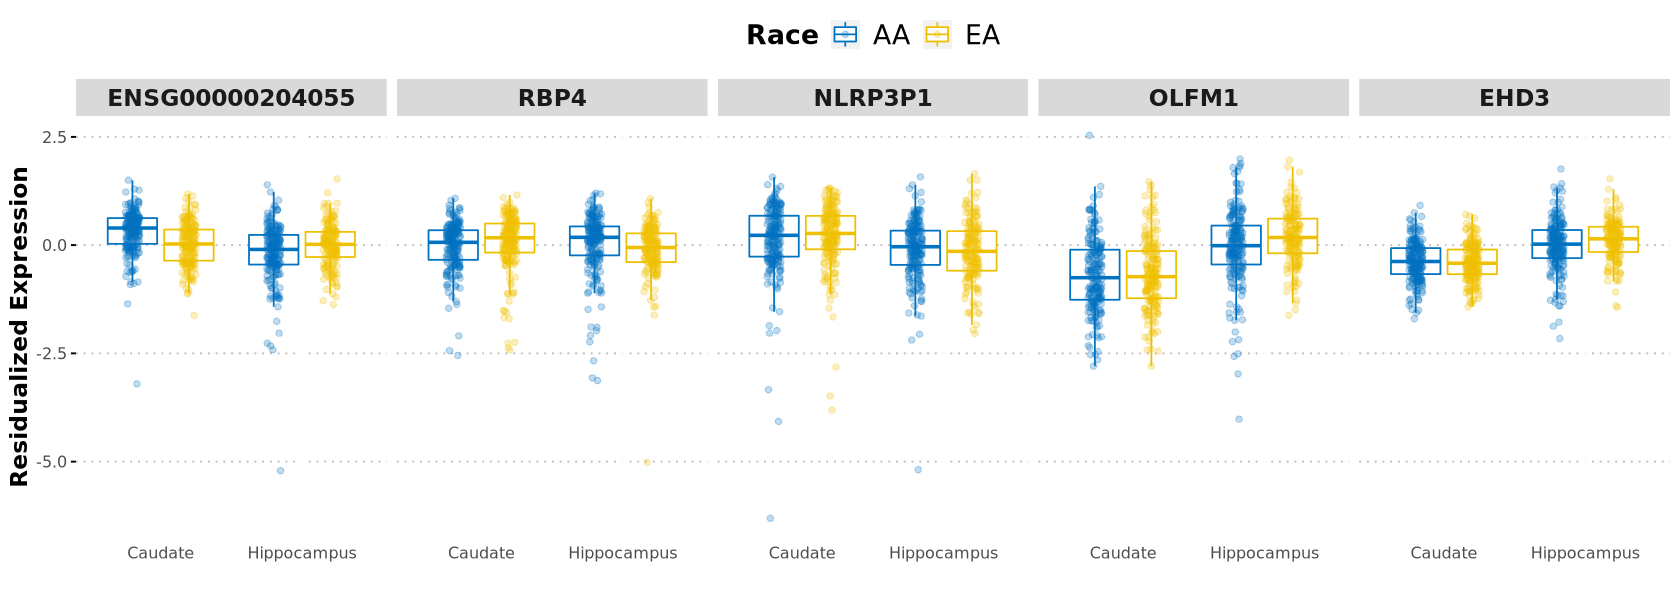

In [35]:
options(repr.plot.width=14, repr.plot.height=5)
bxp_cvh <- ggboxplot(cvh_df, x="Region", y="Res", color="Race", palette="jco",
                     facet.by=c("New_ID"), add='jitter', ncol=5, #ylim=c(-6, 3), 
                     add.params=list(alpha=0.25), xlab='', outlier.shape=NA,
                     panel.labs.font=list(face='bold', size = 14), legend='bottom',
                     ylab='Residualized Expression', ggtheme=theme_pubclean()) +
        font("xy.text", size=12) + 
        font("xy.title", size=14, face="bold") + 
        font("legend.title", size=16, face="bold") + 
        font("legend.text", size=16) + rremove("x.ticks")         
bxp_cvh

### DLPFC vs Hippocampus

In [37]:
fn = '../../_m/disconcordant_genes_dlpfc_hippo.csv'
topDH = data.table::fread(fn) %>% head(5) %>% 
    select(Feature, ensemblID, Symbol, Dir_dlpfc, Dir_hippo, adj.P.Val)
for(xx in seq_along(topDH$Symbol)){
    topDH$New_ID[xx] <- ifelse(topDH$Symbol[xx] == '', 
                               as.character(topDH$ensemblID[xx]), 
                               as.character(topDH$Symbol[xx]))
}
topDH

Feature,ensemblID,Symbol,Dir_dlpfc,Dir_hippo,adj.P.Val,New_ID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000106688.11,ENSG00000106688,SLC1A1,1,-1,2.157437e-05,SLC1A1
ENSG00000138207.13,ENSG00000138207,RBP4,1,-1,1.418758e-04,RBP4
ENSG00000114670.13,ENSG00000114670,NEK11,-1,1,4.192734e-02,NEK11


### Load residualized data and merge with phenotypes

In [38]:
res_file = '../../../../../../test_region_race_interaction/_m/dream_genes/residualized_expression.tsv'
dvh_df = data.table::fread(res_file) %>% 
    filter(Geneid %in% topDH$Feature) %>% 
    column_to_rownames(var="Geneid") %>% 
    t %>% as.data.frame %>% 
    rownames_to_column %>% 
    inner_join(pheno, by=c("rowname" = "RNum")) %>% 
    pivot_longer(-c("rowname", "Region", "Sex", "Race", "Dx"), 
                 names_to="GencodeID", values_to="Res") %>% 
    rename(RNum=rowname) %>% 
    inner_join(topDH, by=c("GencodeID"="Feature")) %>% 
    mutate_at('Symbol', as.factor) %>% 
    filter(Region != 'Caudate')
dvh_df$Race <- factor(droplevels(dvh_df$Race))
dvh_df$Region <- factor(droplevels(dvh_df$Region))
dvh_df$Symbol <- factor(droplevels(dvh_df$Symbol))
levels(dvh_df$Region) <- c('DLPFC', 'Hippocampus')
dvh_df$New_ID = with(dvh_df, reorder(New_ID, adj.P.Val, median))
dvh_df %>% head(2)

RNum,Region,Sex,Race,Dx,GencodeID,Res,ensemblID,Symbol,Dir_dlpfc,Dir_hippo,adj.P.Val,New_ID
<chr>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
R11135,Hippocampus,Male,EA,Control,ENSG00000114670.13,0.9710521,ENSG00000114670,NEK11,-1,1,4.192734e-02,NEK11
R11135,Hippocampus,Male,EA,Control,ENSG00000106688.11,-0.1965492,ENSG00000106688,SLC1A1,1,-1,2.157437e-05,SLC1A1


### Initial ggplot with ggpubr

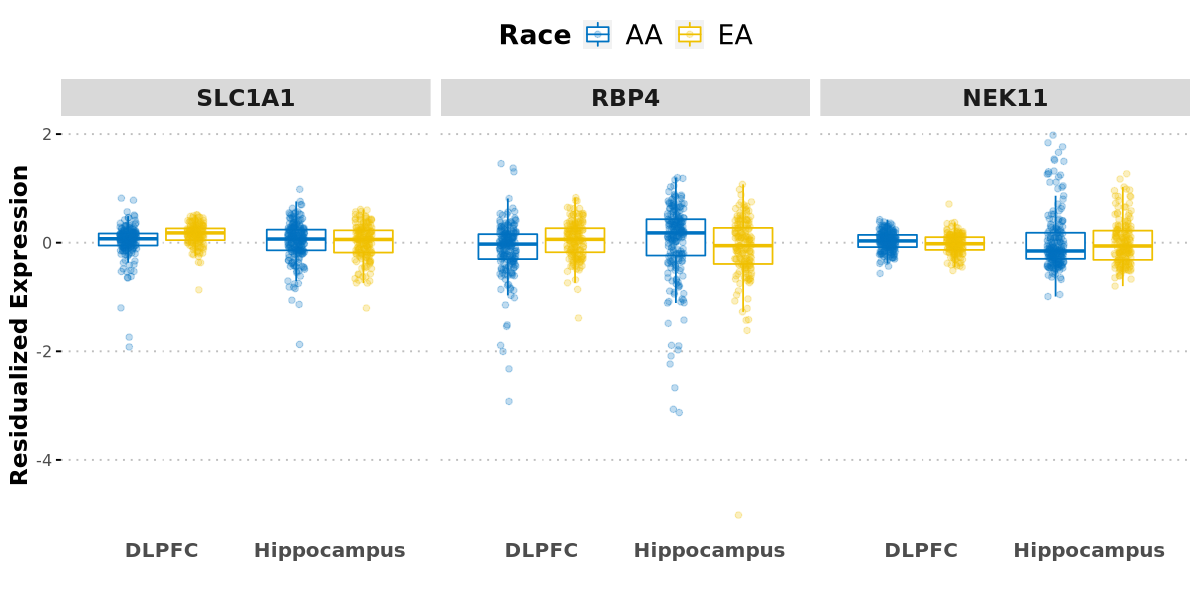

In [46]:
options(repr.plot.width=10, repr.plot.height=5)
bxp_dvh <- ggboxplot(dvh_df, x="Region", y="Res", color="Race", palette="jco",
                     facet.by=c("New_ID"), add='jitter', ncol=5, #ylim=c(-6, 3), 
                     add.params=list(alpha=0.25), xlab='', outlier.shape=NA,
                     panel.labs.font=list(face='bold', size = 14), legend='bottom', 
                     ylab='Residualized Expression', ggtheme=theme_pubclean()) +
        font("xy.text", size=12) +        
        font("xy.title", size=14, face="bold") + 
        font("legend.title", size=16, face="bold") + 
        font("legend.text", size=16) + rremove("x.ticks")         
bxp_dvh

## Arrange plots and annotate

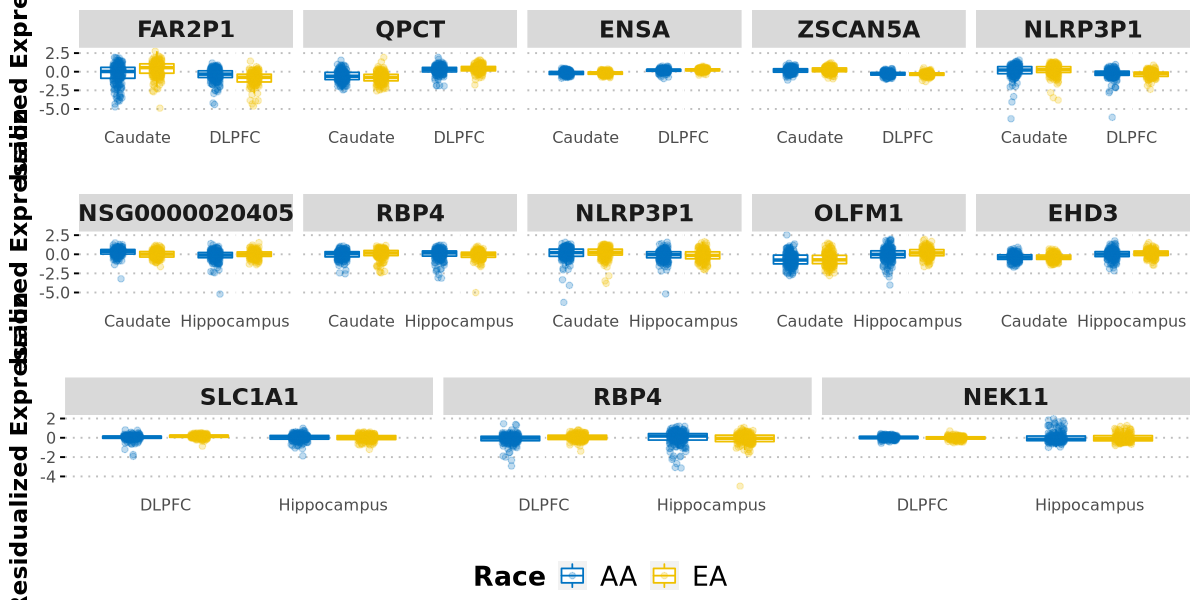

In [44]:
figure <- ggarrange(bxp_cvd, bxp_cvh, bxp_dvh, ncol = 1, nrow = 3, 
                    common.legend=TRUE, legend='bottom')
figure

In [45]:
save_ggplots('discordant_direction_race', figure, 14, 9)
save_ggplots('caudateVdlpfc_discordant_direction_race', bxp_cvd, 14, 5)
save_ggplots('caudateVhippo_discordant_direction_race', bxp_cvh, 14, 5)
save_ggplots('dlpfcVhippo_discordant_direction_race', bxp_dvh, 10, 5)

## Reproducibility information

In [ ]:
print("Reproducibility Information:")
Sys.time()
proc.time()
options(width=120)
sessioninfo::session_info()